# Image Edge 

In [6]:
from numpy import *
from PIL import *
from PIL import Image
from scipy.ndimage import filters


def compute_harris_response(im, sigma=3):
    """
    Gray Scale Image for each pixcel
    
    Define the Harris edge detect response function
    """
    imx = zeros(im.shape)
    filters.gaussian_filter(im, (sigma, sigma), (0, 1), imx)
    imy = zeros(im.shape)
    filters.gaussian_filter(im, (sigma, sigma), (1, 0), imy)
    
    Wxx = filters.gaussian_filter(imx * imx, sigma)
    Wxy = filters.gaussian_filter(imx * imy, sigma)
    Wyy = filters.gaussian_filter(imy * imy, sigma)
    
    Wdet = Wxx * Wyy - Wxy**2
    Wtr = Wxx + Wyy
    
    return Wdet / Wtr

Get Harri Points

In [7]:
def get_harris_points(harrisim, min_dist=10, threshould=0.1):
    coner_threshould = harrisim.max() * threshould
    harrim_t = (harrisim > coner_threshould) * 1
    
    coords = array(harrim_t.nonzero()).T
    
    candidate_values = [harrim_t[c[0], c[1]] for c in coords]
    
    index = argsort(candidate_values)
    
    allowed_locations = zeros(harrisim.shape)
    allowed_locations[min_dist:-min_dist, min_dist:-min_dist] = 1
    
    filtered_coords = []
    for i in index:
        if allowed_locations[coords[i,0], coords[i,1]] == 1:
            filtered_coords.append(coords[i])
            allowed_locations[(coords[i,0] - min_dist):(coords[i,0] + min_dist)
                             ,(coords[i,1] - min_dist):(coords[i,1] + min_dist)]
    return filtered_coords

Show Image

In [8]:
from matplotlib.pyplot import imshow
from pylab import *

%matplotlib inline


def plot_harris_points(image, filtered_coords):
    figure()
    gray()
    imshow(image)
    plot([p[1] for p in filtered_coords], [p[0] for p in filtered_coords], "*")
    axis("off")
    show()

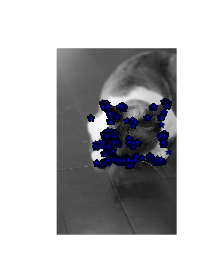

In [9]:
im = array(Image.open("./data/Cat9V9A8958_TP_V1.jpg").convert("L"))
harrsim = compute_harris_response(im)
filtered_coords = get_harris_points(harrsim, 6)
plot_harris_points(im, filtered_coords)

In [44]:
def get_descriptors(image, filtered_coords, wid=5):
    desc = []
    for coords in filtered_coords:
        patch = image[coords[0] - wid:coords[0]+ wid + 1,
                      coords[1] - wid:coords[1] + wid + 1].flatten()
        desc.append(patch)
    return desc

def match(desc1, desc2, threshold=0.5):
    n = len(desc1[0])
    
    d = -ones((len(desc1), len(desc2)))
    for i in range(len(desc1)):
        for j in range(len(desc2)):
            d1 = (desc1[i] - mean(desc1[i])) / std(desc1[i])
            d2 = (desc2[j] - mean(desc2[j])) / std(desc2[j])
            ncc_value = sum(d1 * d2) / (n - 1)
            if ncc_value > threshold:
                d[i, j] = ncc_value
                
    ndx = argsort(-d)
    matchscores = ndx[:, 0]
    
    return matchscores

In [45]:
def match_twosided(desc1, desc2, threshold=0.5):
    matehces_12 = match(desc1, desc2, threshold)
    matehces_21 = match(desc2, desc1, threshold)
    
    ndx_12 = where(matches_12 >= 0)[0]
    
    for n in ndx_12:
        if matches_21[matches_12[n]] != n:
            matches_12[n] = -1
            
    return matches_12

def appendimages(im1, im2):
    rows1 = im1.shape[0]
    rows2 = im2.shape[0]
    
    if rows1 < rows2:
        im1 = concatenate((im1, zeros((rows2 - rows1, im1.shape[1]))), axis=0)
    elif rows1 > rows2:
        im2 = concatenate((im2, zeros((rows1 - rows2, im2.shape[1]))), axis=0)
    
    return concatenate((im1, im2), axis=1)

def plot_matches(im1, im2, locs1, locs2, matchscores, show_below=True):
    im3 = appendimages(im1, im2)
    if show_below:
        im3 = vstack((im3, im3))
    
    imshow(im3)
    
    cols1 = im1.shape[1]
    for i,m in enumerate(matchscores):
        if m > 0:
            plot([locs1[i][1], locs2[m][1] + colos1], [locsp[i][0], locs2[m][0]], "c")
        axis("off")

In [ ]:
wid = 5
im1 = array(Image.open("./data/Cat9V9A8958_TP_V1.jpg").convert("L"))
harrisim = compute_harris_response(im1, 5)
filtered_coords1 = get_harris_points(harrsim, wid+1)
d1 = get_descriptors(im1, filtered_coords1, wid)

im2 = array(Image.open("./data/cat9V9A8973_TP_V1.jpg").convert("L"))
harrisim = compute_harris_response(im2, 5)
filtered_coords2 = get_harris_points(harrsim, wid+1)
d2 = get_descriptors(im1, filtered_coords2, wid)

print("Start Matching")

metches = match_twosided(d1, d2)

In [ ]:
figure()
gray()
plot_matches(im1, im2, filtered_coords1, filtered_coords2, matches)
show()

# Shift

In [15]:
import os

def process_image(imagename, resultname, params="--edge-thresh 10 --peak-thresh 5"):
    if imagename[-3:] != "pgm":
        im = Image.open(imagename).convert("L")
        im.save("tmp.pgm")
        imagename = "tmp.pgm"
    
    cmd = str("sift " + imagename + " --output=" + resultname + " " + params)
    os.system(cmd)
    print("processed " + imagename + " to " + resultname)
    
process_image("./data/cat9V9A8973_TP_V1.jpg", "./data/result_sift.txt")

processed tmp.pgm to ./data/result_sift.txt


In [22]:
def read_features_from_file(filename):
    f = loadtxt(filename)
    return f[:,:4], f[:,4:]

In [23]:
def write_features_to_file(filename, locs, desc):
    savetxt(filename, hstack((locs, desc)))

In [24]:
def plot_features(im, locs, circle=False):
    def draw_circle(c, r):
        t = arange(0, 1.01, .01) * 2 * pi
        x = r * cos(t) + c[0]
        y = r * sin(t) + c[1]
        plot(x,y, 'b', linewidth=2)
    imshow(im)
    if circle:
        for p in locs:
            draw_circle(p[:2], p[2])
    else:
        plot(locs[:, 0], locs[:, 1], "ob")
    axis("off")

processed tmp.pgm to cat.sift


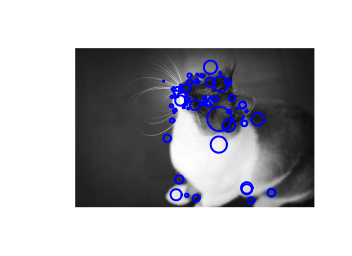

In [26]:
imname = "./data/cat9V9A8973_TP_V1.jpg"

im1 = array(Image.open(imname).convert("L"))
process_image(imname, "cat.sift")
l1, d1 = read_features_from_file("./data/result_sift.txt")

figure()
gray()
plot_features(im1, l1, circle=True)
show()